In [76]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import thermo
import scipy.stats as st

import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

%matplotlib inline


In [77]:
X, y = np.load("dataset/mass_batch.npy"), np.load("dataset/res_v.npy")
initial_X, initial_y = np.load("initial_data/initial_X.npy"), np.load("initial_data/initial_y.npy")

In [79]:
#X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
#initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)

In [8]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI, np.argmax(EI)

Showcasing GPR

In [78]:
# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=initial_X, y_training=initial_y,
    query_strategy=max_EI
)

FOM_gpr = []
# Bayesian optimization
for n_query in range(50):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx], y[query_idx])
    FOM_gpr.append(y[query_idx])

c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceW

In [5]:
optimizer.X_training

array([[0.288, 0.268, 0.444],
       [0.728, 0.252, 0.02 ],
       [0.528, 0.344, 0.128],
       [0.128, 0.436, 0.436],
       [0.572, 0.148, 0.28 ],
       [0.6  , 0.   , 0.4  ],
       [0.54 , 0.22 , 0.24 ],
       [0.496, 0.24 , 0.264],
       [0.576, 0.22 , 0.204],
       [0.   , 0.   , 1.   ],
       [0.244, 0.   , 0.756],
       [0.552, 0.216, 0.232],
       [0.   , 0.004, 0.996],
       [0.6  , 0.256, 0.144],
       [0.464, 0.096, 0.44 ],
       [0.736, 0.068, 0.196],
       [0.536, 0.264, 0.2  ],
       [0.656, 0.168, 0.176],
       [0.056, 0.192, 0.752],
       [0.528, 0.224, 0.248],
       [0.428, 0.572, 0.   ],
       [0.372, 0.432, 0.196],
       [0.968, 0.   , 0.032],
       [0.1  , 0.   , 0.9  ],
       [0.644, 0.068, 0.288],
       [0.132, 0.8  , 0.068],
       [0.248, 0.596, 0.156],
       [0.512, 0.168, 0.32 ],
       [0.532, 0.228, 0.24 ],
       [0.   , 0.008, 0.992],
       [0.   , 0.012, 0.988],
       [0.   , 0.016, 0.984],
       [0.   , 0.02 , 0.98 ],
       [0.

Showcasing BNN (this is v2 of the BNN developed, has more hidden layers than v1)

In [80]:
n_iterations = 50
FOM_values_BNN, EI_arr = [], []

for i in range(1, n_iterations + 1):
    print("Iteration # : {}".format(i))

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=64),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=16),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    )

    #define the loss functions and optimizer needed
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for step in range(250):
        pre = model(initial_X)
        mse = mse_loss(pre, initial_y.reshape(-1, 1))
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    model.eval()

    num_samples = 100  # should give 100 different BNN models to find array of <mean, stdev>
    predictions = torch.zeros((num_samples, X.shape[0]))

    with torch.no_grad():
        for i in range(num_samples):
            y_pred = model(X)
            predictions[i, :] = y_pred.squeeze().detach()
    
    current_objective = y_pred[np.argmax(y_pred)]
    pred_std = predictions.std(dim = 0)
    pred_mean = predictions.mean(dim = 0)

    #acquisition function results
    new_sample, EI, idx = EI_learning(X, y_pred = pred_mean, pred_std = pred_std) #gives new sample X-coords, EI, index of max(EI)
    print("New data point added : {}".format(new_sample))
    print("Corresponding FOM : {}".format(y[idx]))
    print("Target FOM : {}".format(torch.max(y).item()))
    #error_arr.append(np.abs(torch.max(y).item() - y[idx].item()))

    #y_pred_arr.append(pred_mean.detach().numpy().tolist())
    FOM_values_BNN.append(y[idx].item())
    EI_arr.append(EI.detach().numpy().tolist())

    #updates D_n
    initial_X = torch.cat((initial_X, new_sample.reshape(1, 3)))
    initial_y = torch.cat((initial_y, torch.tensor([y[idx].item()], dtype = torch.float)))


Iteration # : 1
- MSE : 2.35, KL : 0.77
New data point added : tensor([0.5680, 0.4320, 0.0000])
Corresponding FOM : 2.0592288970947266
Target FOM : 2.5194807052612305
Iteration # : 2
- MSE : 3.86, KL : 0.81
New data point added : tensor([0.4160, 0.0040, 0.5800])
Corresponding FOM : 1.9968641996383667
Target FOM : 2.5194807052612305
Iteration # : 3
- MSE : 3.52, KL : 0.75
New data point added : tensor([0., 1., 0.])
Corresponding FOM : 1.782888650894165
Target FOM : 2.5194807052612305
Iteration # : 4
- MSE : 4.66, KL : 0.78
New data point added : tensor([0., 0., 1.])
Corresponding FOM : 2.2559053897857666
Target FOM : 2.5194807052612305
Iteration # : 5
- MSE : 3.15, KL : 0.72
New data point added : tensor([0.1960, 0.7080, 0.0960])
Corresponding FOM : 1.9615010023117065
Target FOM : 2.5194807052612305
Iteration # : 6
- MSE : 2.11, KL : 0.75
New data point added : tensor([0.2560, 0.7440, 0.0000])
Corresponding FOM : 1.9148650169372559
Target FOM : 2.5194807052612305
Iteration # : 7
- MSE :

Visualization of GPR vs BNN for same initial training set

It was predicted beforehand that GPR would struggle at higher data domains (N -> inf), and it was proven right. GPR decays at around indice = 25. BNN takes over mostly after that.

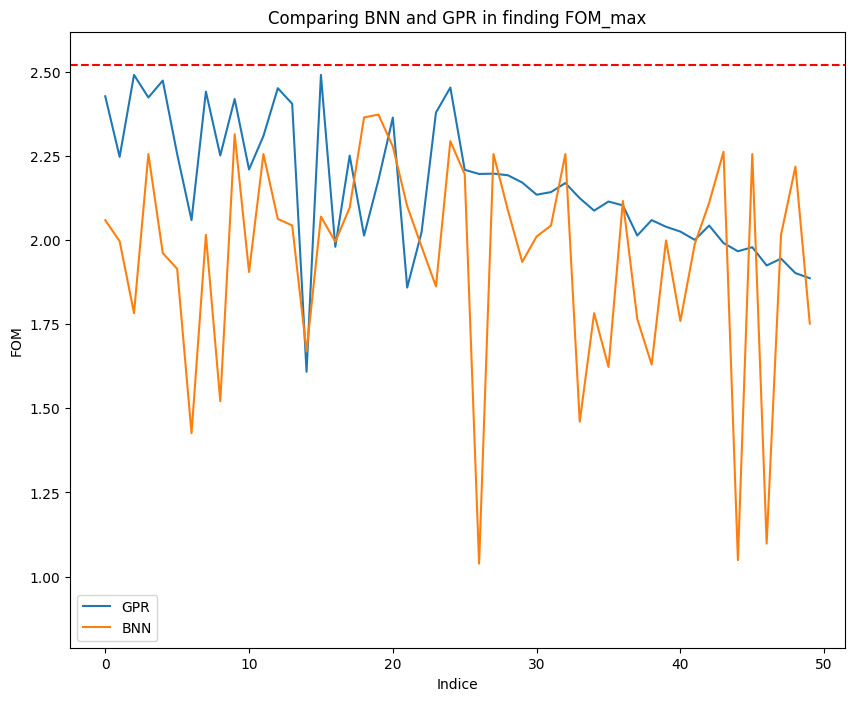

In [81]:
plt.figure(figsize=(10, 8))
plt.plot(FOM_gpr)
plt.plot(FOM_values_BNN)
plt.axhline(y=torch.max(y).item(), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.ylim([np.min(FOM_values_BNN) - 0.25, torch.max(y).item() + 0.1])

plt.title('Comparing BNN and GPR in finding FOM_max')
plt.legend(['GPR', 'BNN'])
plt.show()

Constructing probability model P(S_i | FOM_i)

Following cells will construct switch array s.t. S = {0, 1}, while accepting FOM_i as inputs.

In [17]:
switch, FOM_prob = [], []

for i, j in zip(FOM_values_BNN, FOM_gpr):
    if i > j: #BNN chosen
        switch.append(1)
        FOM_prob.append(i)
    else: #GPR chosen
        switch.append(0)
        FOM_prob.append(j.item())

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [19]:
switch, FOM_prob = np.array(switch), np.array(FOM_prob)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(FOM_prob, switch, test_size = 0.05, random_state = 42)

In [30]:
clf = svm.SVC()
clf.fit(X_train.reshape(-1, 1), y_train)

SVC()

In [31]:
clf.score(X_test.reshape(-1, 1), y_test)

0.8

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test.reshape(-1, 1))))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



Implementing model that dynamically switches between GPR and BNN

P(S_i | FOM_i) predicts on whether it should use GPR or BNN

In [38]:
def GPR(initial_X, initial_y, X, y):
    try:
        initial_X, initial_y = initial_X.detach().numpy(), initial_y.detach().numpy()
        X, y = X.detach().numpy(), y.detach().numpy()
    except:
        pass

    # defining the kernel for the Gaussian process
    kernel = Matern(length_scale=1.0)
    regressor = GaussianProcessRegressor(kernel=kernel)

    # initializing the optimizer
    optimizer = BayesianOptimizer(
        estimator=regressor,
        X_training=initial_X, y_training=initial_y,
        query_strategy=max_EI
    )

    FOM_gpr = []
    # Bayesian optimization
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx], y[query_idx])
    FOM_gpr.append(y[query_idx])
    
    return optimizer.X_training, optimizer.y_training, y[query_idx].item()

In [39]:
def BNN_v2(initial_X, initial_y, X, y):
    n_iterations = 100
    FOM_values, EI_arr = [], []

    try:
        X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
        initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)
    except:
        pass

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=64),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=16),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    )

    #define the loss functions and optimizer needed
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for step in range(250):
        pre = model(initial_X)
        mse = mse_loss(pre, initial_y.reshape(-1, 1))
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    model.eval()

    num_samples = 100  # should give 100 different BNN models to find array of <mean, stdev>
    predictions = torch.zeros((num_samples, X.shape[0]))

    with torch.no_grad():
        for i in range(num_samples):
            y_pred = model(X)
            predictions[i, :] = y_pred.squeeze().detach()
    
    current_objective = y_pred[np.argmax(y_pred)]
    pred_std = predictions.std(dim = 0)
    pred_mean = predictions.mean(dim = 0)

    #acquisition function results
    new_sample, EI, idx = EI_learning(X, y_pred = pred_mean, pred_std = pred_std)
    print("New data point added : {}".format(new_sample))
    print("Corresponding FOM : {}".format(y[idx]))
    print("Target FOM : {}".format(torch.max(y).item()))

    initial_X = torch.cat((initial_X, new_sample.reshape(1, 3)))
    initial_y = torch.cat((initial_y, torch.tensor([y[idx].item()], dtype = torch.float)))

    return initial_X, initial_y, y[idx].item()

In [83]:
n_iterations = 50
FOM_combined = []
#probability_of_optimum, FOM_optimal = [], np.max(y)

for n_point in range(1, n_iterations + 1):
    print("Iteration # : {}".format(n_point))
    if n_point == 1:
        #gpr will be used
        print("Starting with GPR...")
        initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
        FOM_combined.append(FOM_val)
        #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
    
    else:
        if clf.predict([[FOM_combined[-1]]]).item() == 1: #BNN
            print("Switching to BNN...")
            initial_X, initial_y, FOM_val = BNN_v2(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            #probability_of_optimum.append(torch.sum(initial_y < FOM_optimal).item() / len(initial_y))
        
        elif clf.predict([[FOM_combined[-1]]]).item() == 0: #GPR
            print("Switching to GPR...")
            initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
        

Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to GPR...
Iteration # : 4
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 5
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnin

Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct 

Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to BNN...
- MSE : 3.49, KL : 0.77
New data point added : tensor([0.8480, 0.0000, 0.1520])
Corresponding FOM : 2.231292486190796
Target FOM : 2.5194807052612305
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.84, KL : 0.71
New data point added : tensor([0.0000, 0.0680, 0.9320])
Corresponding FOM : 2.0253520011901855
Target FOM : 2.5194807052612305
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.53, KL : 0.80
New data point added : tensor([0.0000, 0.5040, 0.4960])
Corresponding FOM : 1.101224660873413
Target FOM : 2.5194807052612305
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


- MSE : 3.42, KL : 0.75
New data point added : tensor([0.3520, 0.2200, 0.4280])
Corresponding FOM : 2.212867021560669
Target FOM : 2.5194807052612305
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.00, KL : 0.73
New data point added : tensor([0.2080, 0.2920, 0.5000])
Corresponding FOM : 1.7562596797943115
Target FOM : 2.5194807052612305
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.77, KL : 0.74
New data point added : tensor([0.6080, 0.3480, 0.0440])
Corresponding FOM : 2.1583704948425293
Target FOM : 2.5194807052612305
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.65, KL : 0.73
New data point added : tensor([0.6680, 0.0000, 0.3320])
Corresponding FOM : 2.2177724838256836
Target FOM : 2.5194807052612305
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.06, KL : 0.77
New data point added : tensor([0.2560, 0.5280, 0.2160])
Corresponding FOM : 2.0386924743652344
Target FOM : 2.5194807052612305
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.66, KL : 0.76
New data point added : tensor([0.4280, 0.0000, 0.5720])
Corresponding FOM : 2.0298006534576416
Target FOM : 2.5194807052612305
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.60, KL : 0.73
New data point added : tensor([0.5800, 0.0000, 0.4200])
Corresponding FOM : 2.156970739364624
Target FOM : 2.5194807052612305
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.77, KL : 0.75
New data point added : tensor([0.1760, 0.8240, 0.0000])
Corresponding FOM : 1.7861051559448242
Target FOM : 2.5194807052612305
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.09, KL : 0.70
New data point added : tensor([0.1080, 0.8920, 0.0000])
Corresponding FOM : 1.8185919523239136
Target FOM : 2.5194807052612305
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.00, KL : 0.80
New data point added : tensor([0.6920, 0.0000, 0.3080])
Corresponding FOM : 2.269103527069092
Target FOM : 2.5194807052612305
Iteration # : 35
Switching to GPR...
Iteration # : 36
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


- MSE : 3.31, KL : 0.74
New data point added : tensor([0.3080, 0.0000, 0.6920])
Corresponding FOM : 1.9724764823913574
Target FOM : 2.5194807052612305
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.06, KL : 0.75
New data point added : tensor([0.1560, 0.3560, 0.4880])
Corresponding FOM : 1.6162374019622803
Target FOM : 2.5194807052612305
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


- MSE : 3.59, KL : 0.78
New data point added : tensor([0.9320, 0.0520, 0.0160])
Corresponding FOM : 2.049619436264038
Target FOM : 2.5194807052612305
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.81, KL : 0.73
New data point added : tensor([0.2800, 0.2640, 0.4560])
Corresponding FOM : 1.996307134628296
Target FOM : 2.5194807052612305
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.02, KL : 0.76
New data point added : tensor([0.3480, 0.2520, 0.4000])
Corresponding FOM : 2.2181622982025146
Target FOM : 2.5194807052612305
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.73, KL : 0.80
New data point added : tensor([0.5800, 0.0000, 0.4200])
Corresponding FOM : 2.156970739364624
Target FOM : 2.5194807052612305
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.39, KL : 0.80
New data point added : tensor([0.9920, 0.0000, 0.0080])
Corresponding FOM : 1.9728797674179077
Target FOM : 2.5194807052612305
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.92, KL : 0.73
New data point added : tensor([0.4600, 0.5400, 0.0000])
Corresponding FOM : 2.025023937225342
Target FOM : 2.5194807052612305
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.97, KL : 0.78
New data point added : tensor([0.0000, 0.2520, 0.7480])
Corresponding FOM : 1.3332825899124146
Target FOM : 2.5194807052612305
Iteration # : 46
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


Iteration # : 47
Switching to BNN...
- MSE : 4.14, KL : 0.76
New data point added : tensor([0.6440, 0.0000, 0.3560])
Corresponding FOM : 2.251915693283081
Target FOM : 2.5194807052612305
Iteration # : 48
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)


- MSE : 2.88, KL : 0.72
New data point added : tensor([0.2000, 0.8000, 0.0000])
Corresponding FOM : 1.828192114830017
Target FOM : 2.5194807052612305
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
C:\Users\sarta\AppData\Local\Temp\ipykernel_18952\316689035.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.67, KL : 0.78
New data point added : tensor([0.3000, 0.2040, 0.4960])
Corresponding FOM : 2.0104873180389404
Target FOM : 2.5194807052612305


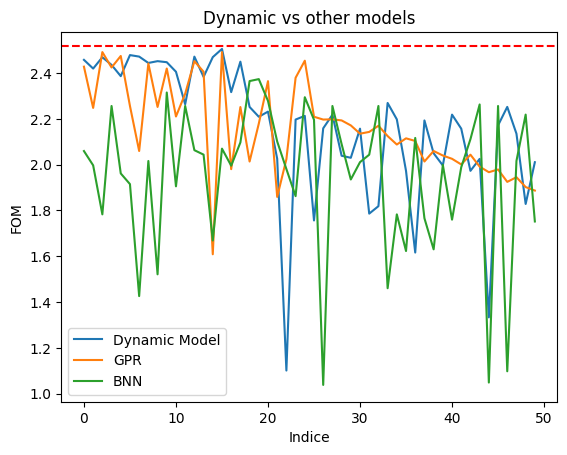

In [85]:
plt.plot(FOM_combined)
plt.plot(FOM_gpr)
plt.plot(FOM_values_BNN)
plt.axhline(y=torch.max(y), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.title('Dynamic vs other models')

plt.legend(['Dynamic Model', 'GPR', 'BNN'])
plt.show()

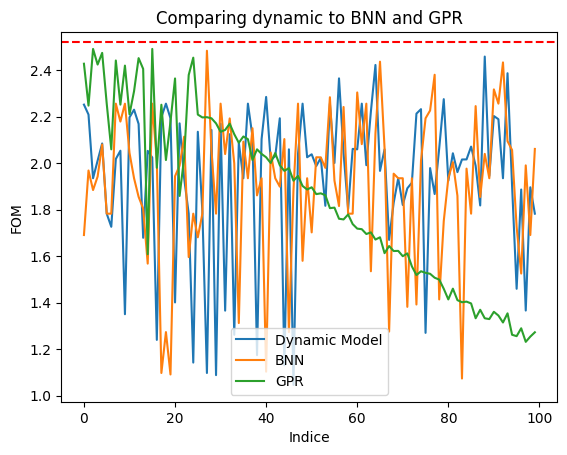

In [51]:
plt.plot(FOM_combined)
plt.plot(FOM_values_BNN)
plt.plot(FOM_gpr)
plt.axhline(y=torch.max(y).item(), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.title('Comparing dynamic to BNN and GPR')

plt.legend(['Dynamic Model', 'BNN', 'GPR'])
plt.show()

In [89]:
FOM_gpr_1 = []

for i in FOM_gpr:
    FOM_gpr_1.append(i.item())

In [90]:
np.sum(np.array(FOM_combined) - np.array(FOM_gpr_1))

0.2142288300106523

In [91]:
np.sum(np.array(FOM_combined) - np.array(FOM_values_BNN))

10.994078874588013